In [1]:
import sys
sys.path.insert(0, '/home/brendalf/Documents/projects/gan-attack/src')

In [2]:
import os
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from math import sqrt, ceil

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import torchvision
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from torchvision.datasets import CIFAR10

from torchsummary import summary

%matplotlib inline

In [3]:
from target.evaluate import evaluate_network

In [4]:
from torch.utils.tensorboard import SummaryWriter

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class SquashTransform:
    def __call__(self, inputs):
        return 2 * inputs - 1
    
data_train = torchvision.datasets.ImageFolder(
    '../data/cifar10_attack_labeled_vgg/',
    transform=torchvision.transforms.Compose([
        ToTensor(),
        SquashTransform()
    ])
)

In [7]:
import torch.backends.cudnn as cudnn

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [8]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Size of outputs
no = 256*4*4

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear = nn.Linear(nz, no, False)
        self.leaky = nn.LeakyReLU(0.2)
        
        self.convt_1 = nn.ConvTranspose2d(ngf*8, ngf*4, (4,4), (2,2), 1)
        self.convt_2 = nn.ConvTranspose2d(ngf*4, ngf*4, (4,4), (2,2), 1)
        self.convt_3 = nn.ConvTranspose2d(ngf*4, ngf*4, (4,4), (2,2), 1)
        
        self.conv2d_1 = nn.Conv2d(ngf*4, 3, (3,3), 1, 1)
        
        self.bnorm_1 = nn.BatchNorm2d(no)
        self.bnorm_2 = nn.BatchNorm2d(ngf*4)
        
        self.tanh = nn.Tanh()

    def forward(self, input):
        input = self.bnorm_1(self.leaky(self.linear(input))).view(-1, 256, 4, 4)
        input = self.bnorm_2(sself.leaky(self.convt_1(input)))
        input = self.bnorm_2(self.leaky(self.convt_2(input)))
        input = self.bnorm_2(self.leaky(self.convt_3(input)))
        input = self.conv2d_1(input)
        
        return self.tanh(input)

In [67]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv2d_1 = nn.Conv2d(nc, ndf*2, (3,3), (1,1), 1)
        self.conv2d_2 = nn.Conv2d(ndf*2, ndf*4, (3,3), (2,2), 1)
        self.conv2d_3 = nn.Conv2d(ndf*4, ndf*4, (3,3), (2,2), 1)
        self.conv2d_4 = nn.Conv2d(ndf*4, ndf*8, (3,3), (2,2), 1)
        
        self.leaky = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        
        self.bnorm_1 = nn.BatchNorm2d(ndf*2)
        self.bnorm_2 = nn.BatchNorm2d(ndf*4)
        self.bnorm_3 = nn.BatchNorm2d(ndf*8)
        
        self.linear = nn.Linear(no, 1)

    def forward(self, input):        
        input = self.bnorm_1(self.leaky(self.conv2d_1(input)))    
        input = self.bnorm_2(self.leaky(self.conv2d_2(input)))
        input = self.bnorm_2(self.leaky(self.conv2d_3(input)))
        input = self.bnorm_3(self.leaky(self.conv2d_4(input)))        
        input = self.flatten(input)        
        input = self.linear(input)
        
        return self.sigmoid(input)

In [68]:
netD = Discriminator().to(device)

In [49]:
netG = Generator().to(device)

In [51]:
netG(torch.randn(10, nz).to(device))[0].shape

torch.Size([3, 32, 32])

In [69]:
netD(netG(torch.randn(10, nz).to(device)))

tensor([[0.5002],
        [0.4982],
        [0.4985],
        [0.5010],
        [0.4999],
        [0.4999],
        [0.4988],
        [0.4973],
        [0.4994],
        [0.4981]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [70]:
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [82]:
BATCH_SIZE = 128

In [83]:
fixed_noise = torch.randn(10, nz).to(device)

real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

c1 = torch.nn.BCELoss()

In [84]:
def trainD(netG, netD, optimizerD, images):
    real_images = images.to(device)

    fake_images = netG(
        torch.randn(BATCH_SIZE, nz).to(device)
    )

    optimizerD.zero_grad()

    real_outputs = netD(real_images)
    fake_outputs = netD(fake_images)

    d_loss = c1(real_outputs, real_labels) + c1(fake_outputs, fake_labels)
    d_loss.backward()

    optimizerD.step()

    return d_loss

In [85]:
def trainG(netG, netD, optimizerG, lambda_ms=0.5):
    z1 = torch.randn(BATCH_SIZE, nz).to(device)
    z2 = torch.randn(BATCH_SIZE, nz).to(device)

    netG.zero_grad()

    images1 = netG(z1)
    images2 = netG(z2)
    
    outputs1 = netD(images1)
    outputs2 = netD(images2)

    mode_loss = lambda_ms * torch.mean(torch.abs(images2 - images1)) / torch.mean(torch.abs(z2 - z1))
    image_loss = c1(outputs1, real_labels) + c1(outputs2, real_labels)

    loss = image_loss + mode_loss
    loss.backward()

    optimizerG.step()

    return loss

In [89]:
def generate_attack(epochs=5001, lms=0.5, lr=2e-4, k=1):
    tb_writer = SummaryWriter()
    
    for n_class in np.arange(10):
        # Initialize Models
        netD = Discriminator().to(device)
        netG = Generator().to(device)

        netD.apply(weights_init)
        netG.apply(weights_init)

        optimizerD = torch.optim.Adam(
            netD.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )

        optimizerG = torch.optim.Adam(
            netG.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )
        
        path_netG = f'../models/adversary/aux_dcgan_{n_class}_netG.pytorch'
        path_netD = f'../models/adversary/aux_dcgan_{n_class}_netD.pytorch'
        path_optG = f'../models/adversary/aux_dcgan_{n_class}_optG.pytorch'
        path_optD = f'../models/adversary/aux_dcgan_{n_class}_optD.pytorch'
        
        indices = np.where(np.array(data_train.targets) == n_class)[0]
        subs = Subset(data_train, indices)
        
        train_loader = DataLoader(
            subs,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )

        num_steps = (len(subs) // BATCH_SIZE) - 1
        
        for epoch in range(epochs):
            d_loss = 0
            g_loss = 0

            for _ in range(k):
                for i, (images, _) in enumerate(train_loader):        
                    if i == num_steps:
                        break
                        
                    d_loss += trainD(netG, netD, optimizerD, images)
            
            for i in range(num_steps):
                g_loss = trainG(netG, netD, optimizerG, lms)


            if epoch % 50 == 0:
                # Tensorboards Logging
                tb_writer.add_scalar(
                    f'DCGANVGG_{n_class}/D Loss',
                    d_loss / num_steps / 2,
                    epoch
                )

                tb_writer.add_scalar(
                    f'DCGANVGG_{n_class}/G Loss',
                    g_loss / num_steps,
                    epoch
                )

                generated = netG(fixed_noise).detach().cpu().view(-1, 3, 32, 32)

                grid = torchvision.utils.make_grid(
                    generated,
                    nrow=5,
                    padding=10,
                    pad_value=1,
                    normalize=True
                )

                tb_writer.add_image(
                    f'DCGANVGG_{n_class}/Output',
                    grid,
                    epoch
                )


            # Save checkpoint
            torch.save(netG.state_dict(), path_netG)
            torch.save(netD.state_dict(), path_netD)
            torch.save(optimizerG.state_dict(), path_optG)
            torch.save(optimizerD.state_dict(), path_optD)
        
        torch.save(netG, f'../models/adversary/g_cifar10_500img_vgg_mseek_{n_class}.pth')
        torch.save(netD, f'../models/adversary/d_cifar10_500img_vgg_mseek_{n_class}.pth')

In [90]:
def launch_attack(training_size=10000):
    for n_class in np.arange(10):
        netG = torch.load(f'../models/adversary/g_cifar10_500img_vgg_mseek_{n_class}.pth').to(device)
        netD = torch.load(f'../models/adversary/d_cifar10_500img_vgg_mseek_{n_class}.pth').to(device)
        
        print(f"Generating images from class {n_class}")
        output_path = os.path.join('../data/copycat_gan_vgg19/', str(n_class))

        if not os.path.exists(output_path):
            os.mkdir(output_path)

        #for i in np.arange(0, 10):
        X = torch.randn(training_size, 100).to(device)
        generated = netG(X)

        for id, image in enumerate(generated):
            #new_id = i + id
            torchvision.utils.save_image(image, fp=os.path.join(output_path, f'{id}.png'))

In [ ]:
generate_attack()

In [18]:
launch_attack(training_size=10000)

Generating images from class 0
Generating images from class 1
Generating images from class 2
Generating images from class 3
Generating images from class 4
Generating images from class 5
Generating images from class 6
Generating images from class 7
Generating images from class 8
Generating images from class 9


In [19]:
transform_test = Compose([
    ToTensor(),
    #Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

imagefolder = torchvision.datasets.ImageFolder(
    '../data/copycat_gan_vgg19/',
    transform=transform_test
)

dataloader = torch.utils.data.DataLoader(
    imagefolder,
    batch_size=32,
    num_workers=4,
    pin_memory=True,
    shuffle=True
)

model = VGG('VGG19')

if device == 'cuda':
    #model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

model = model.to(device)

epochs = 25

output_path = "../models/adversary/copycat.vgg19.pth"

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

Files already downloaded and verified


In [20]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    val_loss = 0.0

    for train_inputs, train_labels in dataloader:
        # get the inputs; data is a list of [inputs, labels]
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        train_outputs = model(train_inputs)
        train_outputs = nn.LogSoftmax(dim=1)(train_outputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += train_loss.item()
    else:
        correct = 0
        val_loss = 0.0

        with torch.no_grad(): # turn off grad
            model.eval() # network in evaluation mode

            for test_inputs, test_labels in testloader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

                test_outputs = model(test_inputs)
                test_outputs = nn.LogSoftmax(dim=1)(test_outputs)
                test_loss = criterion(test_outputs, test_labels)
                val_loss += test_loss.item()

                _, predicted = test_outputs.max(1)
                correct += (predicted == test_labels).sum().item()

    acc = (100 * correct / len(testset))
    print('E: {}/{} [train_loss: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}]'.format(epoch+1, epochs, running_loss, val_loss, acc))

E: 1/25 [train_loss: 30450.403, val_loss: 60975.821, val_acc: 19.530]
E: 2/25 [train_loss: 1836.156, val_loss: 55430.568, val_acc: 23.430]
E: 3/25 [train_loss: 726.573, val_loss: 64531.888, val_acc: 21.910]
E: 4/25 [train_loss: 390.401, val_loss: 61354.145, val_acc: 21.630]
E: 5/25 [train_loss: 295.080, val_loss: 65217.560, val_acc: 22.510]
E: 6/25 [train_loss: 253.034, val_loss: 60781.132, val_acc: 22.650]
E: 7/25 [train_loss: 112.586, val_loss: 65451.527, val_acc: 21.930]
E: 8/25 [train_loss: 42.877, val_loss: 67987.424, val_acc: 21.760]
E: 9/25 [train_loss: 33.756, val_loss: 63632.924, val_acc: 22.950]
E: 10/25 [train_loss: 34.602, val_loss: 64951.542, val_acc: 22.280]
E: 11/25 [train_loss: 18.513, val_loss: 67889.825, val_acc: 22.100]
E: 12/25 [train_loss: 15.035, val_loss: 69977.850, val_acc: 21.550]
E: 13/25 [train_loss: 15.478, val_loss: 65575.091, val_acc: 22.950]
E: 14/25 [train_loss: 14.308, val_loss: 68117.479, val_acc: 22.000]
E: 15/25 [train_loss: 10.617, val_loss: 71178.4

In [ ]:
df = next(iter(testloader))

In [21]:
inputs, labels = df
inputs, labels = inputs.to(device), labels.to(device)

In [22]:
labels.size(0)

32

In [23]:
outputs = model(inputs)

In [24]:
outputs.max(1)

torch.return_types.max(
values=tensor([ 8.6694,  8.6706,  8.6616,  8.6750,  7.5286,  8.6655,  8.6662,  7.2192,
         8.6749,  8.7016,  8.6727,  7.3828,  8.6647,  8.6686, 14.0442,  8.6698,
         8.6724,  8.8760,  8.6993,  8.6639,  8.6673,  8.6754,  8.7319,  8.7352,
         8.7297,  7.6334, 17.4880,  8.6879,  8.6771,  8.6655,  8.6658,  8.6633],
       grad_fn=<MaxBackward0>),
indices=tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9]))

In [17]:
#if os.path.exists(path_netG):
#    print("Loading NetG")
#    netG.load_state_dict(torch.load(path_netG))

#if os.path.exists(path_netD):
#    print("Loading NetD")
#    netD.load_state_dict(torch.load(path_netD))

#if os.path.exists(path_optG):
#    print("Loading OptG")
#    optimizerG.load_state_dict(torch.load(path_optG))

#if os.path.exists(path_optD):
#    print("Loading OptD")
#    optimizerD.load_state_dict(torch.load(path_optD))

In [27]:
real_labels

tensor([0, 3, 6, 0, 1, 5, 4, 6, 0, 5, 9, 6, 4, 4, 6, 4, 7, 1, 3, 4, 8, 8, 9, 1,
        9, 6, 3, 7, 5, 1, 8, 8])

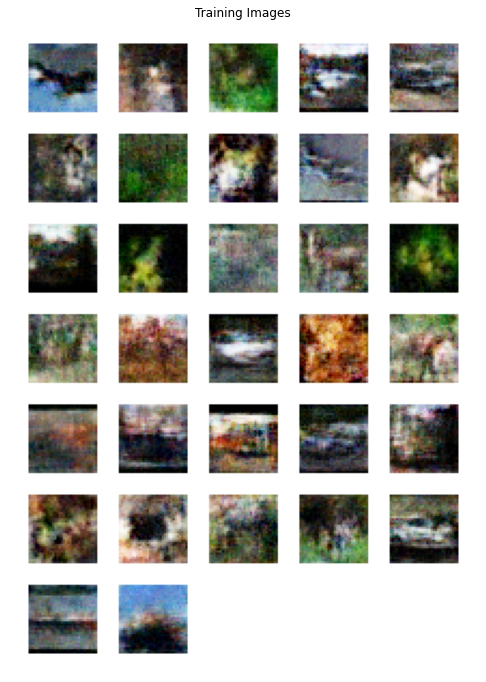

In [26]:
real_images, real_labels = next(iter(dataloader))

plt.figure(figsize=(22, 12))
plt.axis('off')
plt.title('Training Images')

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_images.to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(sqrt(32))
        ).cpu(),
        (1, 2, 0)
    )
);

In [ ]:
generated = netG(fixed_noise).detach().cpu().view(-1, 3, 32, 32)

grid = torchvision.utils.make_grid(
    generated,
    padding=10,
    pad_value=1,
    normalize=True,
    nrow=5
)

fig = plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);